# Statistical Arbitrage
Bond Pairs Trade Ideas

The idea behind this notebook is to begin looking at pairs trading for the 10Y vs 5Y US Treasury Bonds. This strategy works well with the pair is stationary, range bound and when there is high volatility.

We start very simple to explore and create a trade idea pipeline, which we will expand upon, make increasingly complex and creative.

Firstly, we created methods for the following:-

1. Download Data from Yahoo Finance

2. Test for Stationarity  
   We use the Augmented Dickey Fuller test to check our data mean reverts

3. Compute Spread and Feature Data  
   We compute spread data, mean, std and bollinger bands here
   
4. Plot Bond Yields

5. Plot Bond Spread for a given Bond Pair

6. Plot Bond Spread Returns 
   To check for stationarity of bond spread returns
   
Secondly, we apply these methods to explore the viability of the trading idea

Thirdly, we implement trading features that define our entry and exit points

Forthly, we create a back testing tear sheet using quantstats

**TODO:**  
Fifthly, add additional trading features, apply market regime indicators, increase complexity and creativity. Generally a handful of features will be required to have any chance of being successful.

Once we have completed these steps we will have a basic bond pairs trading pipepline for backtesting, which we can configure and use to test other pairs and trading ideas.

In [1]:
# Import Packages
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.api import OLS
import quantstats as qs

# Allow Multiple Outputs in Cells
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Disable Warnings
import warnings
warnings.filterwarnings('ignore')

## Define Data Labels
We define labels here so that if we need to correct a label we can do it one place, rather than everywhere!

In [2]:
# Define Column Names and Labels
# We do this here so that if we need to correct a label we can do it one place, rather than everywhere!

# Chart Labels
DATE = 'date'
PRICE = 'price'
YIELD = 'yield'

# Yahoo Finance Labels
CLOSE = 'Adj Close'

# Pandas DataFrame Labels for Spread
SPREAD = 'spread'
MEAN = 'mean'
STD = 'std'
SPREAD_RETURNS = 'spread_returns'
SPREAD_VS_MEAN = 'spread_vs_mean'

# Pandas DataFrame Labels for Features

# Bollinger Bands
BBAND = 'bollinger band'
BB_UPPER1 = 'bb_upper1'
BB_UPPER2 = 'bb_upper2'
BB_LOWER1 = 'bb_lower1'
BB_LOWER2 = 'bb_lower2'

# Z-Score and Standard Deviation Bounds
Z_SCORE = 'z_score'
Z_UPPER1 = 'z_upper1'
Z_UPPER2 = 'z_upper2'
Z_LOWER1 = 'z_lower1'
Z_LOWER2 = 'z_lower2'

# Back Testing Parameters
SIGNAL = 'signal'
POSITION = 'position'
STRATEGY_RETURNS = 'Strategy_Returns'

## Function Implementation

### Data Methods

In [3]:
# Method to download data from yahoo finance
def download_data(tickers, start_date, end_date):
    prices = yf.download(tickers, start=start_date, end=end_date)[CLOSE]
    return prices

# Method to read bond data from an Excel file
def import_excel_data(file_path, sheet_name, start_date, end_date):
    
    # import data
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    
    # filter data to match our choosen date range
    filtered_df = df[(df[DATE] >= start_date) & (df[DATE] <= end_date)]
    
    # set date column as index
    filtered_df.set_index(DATE, inplace=True)
    
    return filtered_df

# Method to test for stationarity using the Augmented Dickey-Fuller Test
def test_stationarity(series_data):
    # Perform Dickey-Fuller test
    result = adfuller(series_data)
    p_value = result[1]

    # Test if p-value < 0.05
    is_stationary = p_value < 0.05
    message = 'Stationary' if is_stationary else 'Not Stationary'
    
    print(f'Series is {message} (p-value: {p_value*100:.2f}%)')

# Compute the Spread Data and Add to DataFrame
# window controls the mean and std period in days
def append_spread_data(price_data, window, long_duration_bond, short_duration_bond):
    
    # We compute spread using yields[1] - yields[0] i.e. short bond tenor first
    long_series = price_data[long_duration_bond]
    short_series = price_data[short_duration_bond]
    
    # Compute the hedge ratio using Ordinary Least Squares regression (OLS)
    model = OLS(long_series, short_series)
    model = model.fit() 
    hedge_ratio = model.params[0]
    
    # Compute the Spread using Hedge Ratio
    price_data[SPREAD] = long_series - hedge_ratio * short_series

    # Calculate the Moving Average and standard deviation
   
    # Simple Moving Average (uncomment to use)
    #price_data[MEAN] = price_data[SPREAD].rolling(window=window).mean()
    
    # Exponentially Weighted Moving Average (EWM)
    price_data[MEAN] = price_data[SPREAD].ewm(span=window, adjust=False).mean()
    price_data[STD] = price_data[SPREAD].rolling(window=window).std()
    
    # Compute Spread Returns
    
    ## LOG RETURNS - Calculate the Return of each series independently then take the difference
    ## -----------
    #long_series_returns = np.log(long_series / long_series.shift(1))
    #short_series_returns = np.log(short_series / short_series.shift(1))
    #price_data[SPREAD_RETURNS] = long_series_returns - short_series_returns
    #price_data[SPREAD_RETURNS][0] = 0
    
    ## SIMPLE RETURNS - Calculate the Return of each series independently then take the difference
    ## --------------
    long_series_returns = long_series.pct_change()
    short_series_returns = short_series.pct_change()
    price_data[SPREAD_RETURNS] = long_series_returns - short_series_returns
    price_data[SPREAD_RETURNS][0] = 0
    
    # Some spreads will be zero, when dividing by zero for returns this will give 'infinity' (inf) as the result
    # Here we replace +/- inf with not a number (nan) and then replace this nan with the raw spread value
    price_data[SPREAD_RETURNS] = price_data[SPREAD_RETURNS].replace([np.inf, -np.inf], np.nan)
    price_data[SPREAD_RETURNS] = price_data[SPREAD_RETURNS].fillna(price_data[SPREAD])
    
    # Compute Spread vs Mean
    price_data[SPREAD_VS_MEAN] = price_data[SPREAD_RETURNS] - price_data[MEAN]

### Bond Charting Methods

In [4]:
# Method to plot price data
def plot_prices(prices):
    plt.figure(figsize=(10, 6))
    for ticker in prices.columns:
        plt.plot(prices.index, prices[ticker], label=ticker)

    plt.title(PRICE)
    plt.xlabel(DATE)
    plt.ylabel(PRICE)
    plt.legend()
    plt.show()

# Method to plot yield data
def plot_yields(yields):
    plt.figure(figsize=(10, 6))
    for ticker in yields.columns:
        plt.plot(yields.index, yields[ticker], label=ticker)

    plt.title(YIELD)
    plt.xlabel(DATE)
    plt.ylabel(YIELD)
    plt.legend()
    plt.show()

# Method to plot the spread and rolling mean
def plot_spread(spread_data):
    
    plt.figure(figsize=(10, 4))
    plt.plot(spread_data.index, spread_data[SPREAD], label=SPREAD, color='red')
    plt.plot(spread_data.index, spread_data[MEAN], label=MEAN, color='black', linestyle='--')
    
    plt.title(SPREAD)
    plt.xlabel(DATE)
    plt.ylabel(SPREAD)
    
    plt.legend()
    plt.show()
    
# Method to plot the spread returns
def plot_spread_returns(spread_data):
    
    plt.figure(figsize=(10, 4))
    plt.plot(spread_data.index, spread_data[SPREAD_RETURNS], label=SPREAD_RETURNS, color='red')
    
    plt.title(SPREAD_RETURNS)
    plt.xlabel(DATE)
    plt.ylabel(SPREAD_RETURNS)
    
    plt.legend()
    plt.show()

### Feature Data and Feature Charting Methods

In [5]:
# Compute Feature Data and Add to DataFrame
# window controls the mean and std period in days
# num_std is used to set the bollinger bands i.e. as a mulitple of number of standard deviations (num_std)
def append_feature_data(price_data, window, num_std):

    # 1. Bollinger Bands
    # Compute Bollinger Bands as a multiple of number of standard deviations specified by num_std hyper-parameter
    price_data[BB_UPPER1] = price_data[MEAN] + (1 * num_std * price_data[STD])
    price_data[BB_UPPER2] = price_data[MEAN] + (2 * num_std * price_data[STD])
    price_data[BB_LOWER1] = price_data[MEAN] - (1 * num_std * price_data[STD])
    price_data[BB_LOWER2] = price_data[MEAN] - (2 * num_std * price_data[STD])
    
    # 2. Z-Score and Z-Score Standard Deviation Bands scaled by input hyper-parameter num_std
    price_data[Z_SCORE] = (price_data[SPREAD] - price_data[MEAN]) / (num_std * price_data[STD])
    price_data[Z_UPPER1] = + 1 * num_std
    price_data[Z_UPPER2] = + 2 * num_std
    price_data[Z_LOWER1] = - 1 * num_std
    price_data[Z_LOWER2] = - 2 * num_std
    
# Method to plot the spread, mean and bollinger bands
def plot_spread_with_bollinger_bands(spread_data):
    
    plt.figure(figsize=(10, 4))
    plt.plot(spread_data.index, spread_data[SPREAD], label=SPREAD, color='red')
    plt.plot(spread_data.index, spread_data[MEAN], label=MEAN, color='black', linestyle='--')
    
    plt.plot(spread_data.index, spread_data[BB_UPPER1], label=BB_UPPER1, color='green')
    plt.plot(spread_data.index, spread_data[BB_UPPER2], label=BB_UPPER2, color='blue')
    
    plt.plot(spread_data.index, spread_data[BB_LOWER1], label=BB_LOWER1, color='green')
    plt.plot(spread_data.index, spread_data[BB_LOWER2], label=BB_LOWER2, color='blue')
    
    plt.title(BBAND)
    plt.xlabel(DATE)
    plt.ylabel(SPREAD)
    
    plt.legend()
    plt.show()
    
# Method to plot the spread, mean and bollinger bands
def plot_z_scores(spread_data):
    
    plt.figure(figsize=(10, 4))
    plt.plot(spread_data.index, spread_data[Z_SCORE], label=Z_SCORE, color='red')
    
    # Zero Standard Deviation Line
    plt.axhline(y=0, color='black', linestyle='--')
    
    plt.plot(spread_data.index, spread_data[Z_UPPER1], label=Z_UPPER1, color='green')
    plt.plot(spread_data.index, spread_data[Z_UPPER2], label=Z_UPPER2, color='blue')
    
    plt.plot(spread_data.index, spread_data[Z_LOWER1], label=Z_LOWER1, color='green')
    plt.plot(spread_data.index, spread_data[Z_LOWER2], label=Z_LOWER2, color='blue')
    
    plt.title(Z_SCORE)
    plt.xlabel(DATE)
    plt.ylabel(Z_SCORE)
    
    plt.legend()
    plt.show()

## Perform Bond Yield and Spread Analysis
Here we perform preliminary bond spread analysis

### Download Data and Plot Bond Yields
Here we define the bond pairs, start- and end-dates. **Importantly we also define the feature hyper-parameters here!**

^FVX        ^TNX
date                              
2023-01-03  108.015625  112.640625
2023-01-04  108.312500  113.187500
2023-01-05  108.140625  113.015625
2023-01-06  109.023438  114.218750
2023-01-09  109.296875  114.625000
2023-01-10  108.953125  114.000000
2023-01-11  109.226562  114.437500
2023-01-12  109.781250  115.234375
2023-01-13  109.429688  114.765625
2023-01-17  109.492188  114.671875

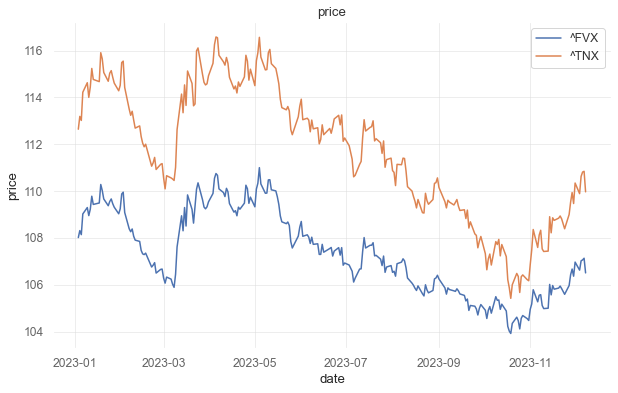

In [6]:
# Define bond tickers
# ^IRX is the 13 Week US Treasury Bill
# ^FVX is the 5-Year US Treasury
# ^TNX is the 10-Year US Treasury
# ^TYX is the 30-Year US Treasury

# Bond Analysis and Feature Parameters 
bond_tickers = ['^TNX', '^FVX'] # 10 v 5
long_duration_bond = '^TNX'
short_duration_bond = '^FVX'
start_date = '2023-01-01'
end_date = '2023-12-08'
moving_average_period = 30
num_std = 1.0

# Excel Workbook Data
excel_path = r'C:\Users\Nicholas Burgess\Desktop\StatArb\ust_data.xlsx'
excel_sheet = 'fvx_tnx'
use_excel_data = True

if use_excel_data:
    
    # Excel Data in Price Format
    # --------------------------
    
    # Import bond data from Excel
    bond_data = import_excel_data(excel_path, excel_sheet, start_date, end_date)
    bond_data.head(10)

    # Plot bond prices
    plot_prices(bond_data)

else:
    
    # Yahoo Finance Data in Yield Format
    # ----------------------------------
    
    # Get bond data from Yahoo Finance!
    bond_data = download_data(bond_tickers, start_date, end_date)
    bond_data.head(10)

    # Plot bond yields
    plot_yields(bond_data)

### Plot Spread Data and Test for Stationarity
Here we compute the spread data, plot the spread and test for stationarity or cointegration.

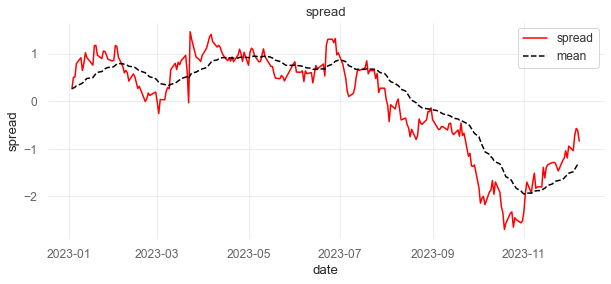

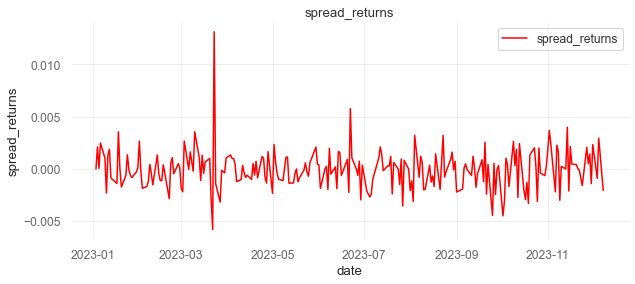


Testing if Spread is Stationary
Series is Not Stationary (p-value: 67.81%)

Testing if Spread Returns are Stationary
Series is Stationary (p-value: 0.00%)


In [7]:
# Compute Spread Data
append_spread_data(bond_data, moving_average_period, long_duration_bond, short_duration_bond)

# Plot spread
plot_spread(bond_data)

# Plot spread Returns
plot_spread_returns(bond_data)

# Test Spread is Stationary
print(f'\nTesting if Spread is Stationary')
test_spread = bond_data[SPREAD]
test_stationarity(test_spread.dropna())

# Test Spread Returns are Stationary
print(f'\nTesting if Spread Returns are Stationary')
test_spread_returns = bond_data[SPREAD_RETURNS]
test_stationarity(test_spread_returns.dropna())

### Compute and Plot Feature Data

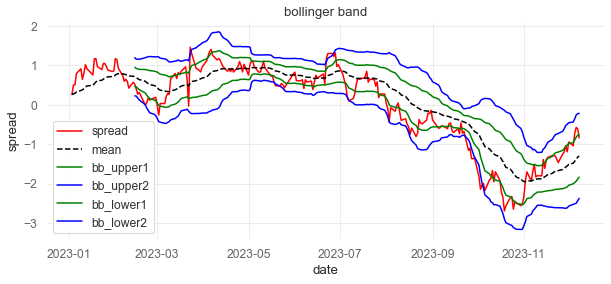

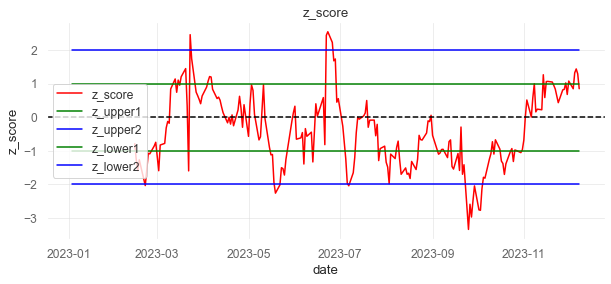

In [8]:
# Compute Feature Data
append_feature_data(bond_data, moving_average_period, num_std)

# Plot Features
plot_spread_with_bollinger_bands(bond_data)
plot_z_scores(bond_data)

### Apply Features & Define Entry Exit Points
In this particular context, the features define the trading strategy entry and exit points. The entry and exit positions are applied by updating a position variable that is -1 for short, +1 for long and 0 for no position.

In [9]:
# Method to apply the z-score to define entry and exit points
def apply_z_score(bond_data):
    
    # Initialize Positions
    bond_data[SIGNAL] = 0
    bond_data[POSITION] = 0
    
    # ENTRY SIGNALS - Using Vectorization for Speed
    # =============
    
    long_entry_condition = ((bond_data[Z_SCORE].shift(1) < bond_data[Z_LOWER2]) 
                            & (bond_data[Z_SCORE] > bond_data[Z_LOWER2]))
    
    short_entry_condition = ((bond_data[Z_SCORE].shift(1) > bond_data[Z_UPPER2])
                            & (bond_data[Z_SCORE] < bond_data[Z_UPPER2]))
        
    # LONG ENTRY
    bond_data.loc[long_entry_condition, SIGNAL] = 1
    
    # SHORT ENTRY
    bond_data.loc[short_entry_condition, SIGNAL] = -1
    
    # ENTRY POSITIONS
#     bond_data[POSITION] = bond_data[SIGNAL]
#     bond_data[POSITION] = bond_data[POSITION].replace(0, method='ffill')
    
    
    # EXIT SIGNALS - Using a Simple Loop with No Vectorization due to Data Dependencies
    # ============

    current_position = 0
    
    for i, position in enumerate(bond_data[POSITION]):
        
        # Skip first element, too early to exit a position
        if i == 0:
            continue
        
        # Update SIGNAL and POSITION
        current_signal = bond_data[SIGNAL][i]
        if current_position == 0:
            current_position = 1 if (current_signal == 1) else -1 if (current_signal == -1) else current_position
                                     
        # LONG EXIT (TAKE PROFIT)
        if ((current_position == 1) and ((bond_data[Z_SCORE][i-1] < 0) and (bond_data[Z_SCORE][i] > 0))):
            bond_data[SIGNAL][i] = -1
            current_position = 0

        # LONG EXIT (STOP LOSS)
        if ((current_position == 1) and ((bond_data[Z_SCORE][i-1] > bond_data[Z_LOWER2][i]) and (bond_data[Z_SCORE][i] < bond_data[Z_LOWER2][i]))):
            bond_data[SIGNAL][i] = -1
            current_position = 0
        
        # SHORT EXIT (TAKE PROFIT)
        if ((current_position == -1) and ((bond_data[Z_SCORE][i-1] > 0) and (bond_data[Z_SCORE][i] < 0))):
            bond_data[SIGNAL][i] = 1
            current_position = 0

        # SHORT EXIT (STOP LOSS)
        if ((current_position == -1) and ((bond_data[Z_SCORE][i-1] < bond_data[Z_UPPER2][i]) and (bond_data[Z_SCORE][i] > bond_data[Z_UPPER2][i]))):
            bond_data[SIGNAL][i] = 1
            current_position = 0
    
    # UPDATE POSITION
    bond_data[POSITION] = bond_data[SIGNAL].cumsum()
    
    # Close-out final position for accurate back-testing reporting
    bond_data[POSITION].iloc[-1] = 0


# Method to plote the spread and trade entry and exit points
def plot_entry_exit_points(bond_data):
    
    fig, ax1 = plt.subplots(figsize=(10, 4))
    ax2 = ax1.twinx()
    
    ax1.plot(bond_data.index, bond_data[SPREAD], label=SPREAD, color='red')
    ax2.plot(bond_data.index, bond_data[POSITION], label=POSITION, color='green')
    
    ax1.set_xlabel(DATE)
    ax1.set_ylabel(SPREAD, color='red')
    ax2.set_ylabel(POSITION, color='green')
    
    plt.title(SPREAD)
    plt.show()

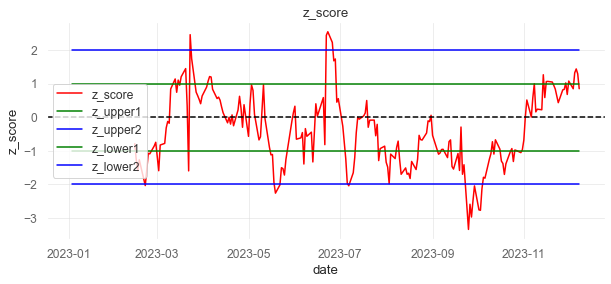

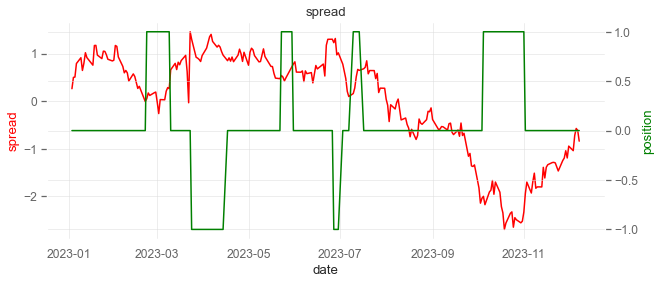

In [10]:
# Apply the Feature(s) and Plot the Entry Exit Points
apply_z_score(bond_data)
plot_z_scores(bond_data)
plot_entry_exit_points(bond_data)

## Run the Strategy Back Test

In [11]:
# Method to compute strategy returns    
def run_back_test(bond_data):
    
    # Strategy Return is the Spread Return scaled by the Position direction 
    bond_data[STRATEGY_RETURNS] = bond_data[SPREAD_RETURNS] * bond_data[POSITION].shift(1)
    
    # Finally fill any blanks with zero
    bond_data[STRATEGY_RETURNS] = bond_data[STRATEGY_RETURNS].fillna(0)
    
    # Generate analytics using the QuantStats library
    qs.reports.basic(bond_data[STRATEGY_RETURNS])

                    Strategy
------------------  ----------
Start Period        2023-01-03
End Period          2023-12-08
Risk-Free Rate      0.0%
Time in Market      27.0%

Cumulative Return   2.08%
CAGR﹪              1.55%

Sharpe              1.64
Prob. Sharpe Ratio  94.84%
Sortino             2.74
Sortino/√2          1.94
Omega               1.68

Max Drawdown        -0.98%
Longest DD Days     58

Gain/Pain Ratio     0.68
Gain/Pain (1M)      4.24

Payoff Ratio        1.14
Profit Factor       1.68
Common Sense Ratio  3.29
CPC Index           1.14
Tail Ratio          1.95
Outlier Win Ratio   12.87
Outlier Loss Ratio  2.35

MTD                 0.0%
3M                  0.07%
6M                  0.93%
YTD                 2.08%
1Y                  2.08%
3Y (ann.)           1.55%
5Y (ann.)           1.55%
10Y (ann.)          1.55%
All-time (ann.)     1.55%

Avg. Drawdown       -0.25%
Avg. Drawdown Days  14
Recovery Factor     2.11
Ulcer Index         0.0
Serenity Index      2.16


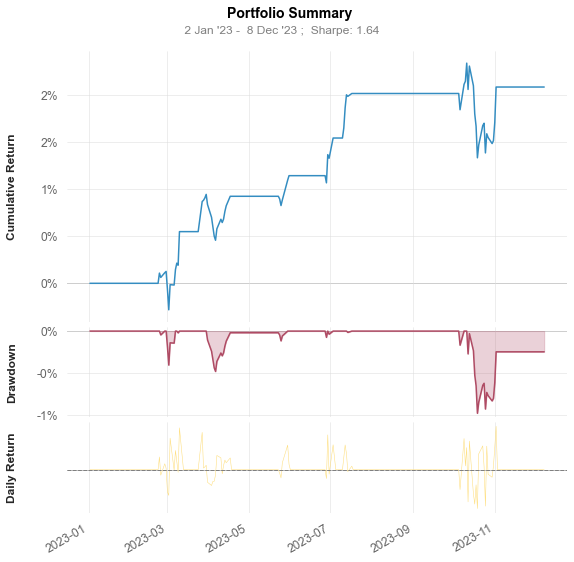

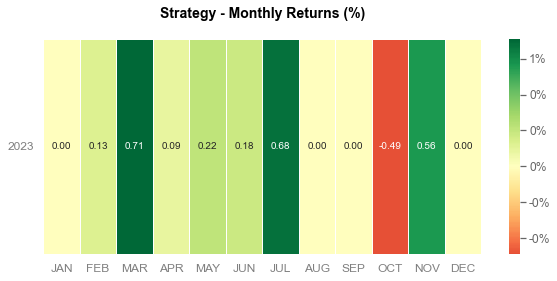

In [12]:
# Run the Backtest to Compute Strategy returns
run_back_test(bond_data)

## Inspect / Export the Underlying Data

In [16]:
# Display Bond Data
bond_data.head()
bond_data.tail()

# Export Bond Data to Excel (uncomment to use)
#bond_data.to_excel('ust10-5.xlsx', index=True)

^FVX        ^TNX    spread      mean  std  spread_returns  \
date                                                                          
2023-01-03  108.015625  112.640625  0.262841  0.262841  NaN        0.000000   
2023-01-04  108.312500  113.187500  0.500852  0.278197  NaN        0.002107   
2023-01-05  108.140625  113.015625  0.507793  0.293009  NaN        0.000068   
2023-01-06  109.023438  114.218750  0.792454  0.325232  NaN        0.002482   
2023-01-09  109.296875  114.625000  0.914223  0.363231  NaN        0.001049   

            spread_vs_mean  bb_upper1  bb_upper2  bb_lower1  bb_lower2  \
date                                                                     
2023-01-03       -0.262841        NaN        NaN        NaN        NaN   
2023-01-04       -0.276090        NaN        NaN        NaN        NaN   
2023-01-05       -0.292941        NaN        NaN        NaN        NaN   
2023-01-06       -0.322749        NaN        NaN        NaN        NaN   
2023-01-09       -0.362182        NaN        NaN        NaN        NaN   

            z_score  z_upper1  z_upper2  z_lower1  z_lower2  signal  position  \
date                                                                            
2023-01-03      NaN       1.0       2.0      -1.0      -2.0       0         0   
2023-01-04      NaN       1.0       2.0      -1.0      -2.0       0         0   
2023-01-05      NaN       1.0       2.0      -1.0      -2.0       0         0   
2023-01-06      NaN       1.0       2.0      -1.0      -2.0       0         0   
2023-01-09      NaN       1.0       2.0      -1.0      -2.0       0         0   

            Strategy_Returns  
date                          
2023-01-03               0.0  
2023-01-04               0.0  
2023-01-05               0.0  
2023-01-06               0.0  
2023-01-09               0.0

^FVX        ^TNX    spread      mean       std  \
date                                                               
2023-12-04  106.625000  109.890625 -1.040374 -1.483395  0.523461   
2023-12-05  107.023438  110.625000 -0.720527 -1.434177  0.539947   
2023-12-06  107.062500  110.812500 -0.573667 -1.378661  0.560498   
2023-12-07  107.132812  110.843750 -0.615569 -1.329429  0.553180   
2023-12-08  106.507812  109.968750 -0.840329 -1.297874  0.539883   

            spread_returns  spread_vs_mean  bb_upper1  bb_upper2  bb_lower1  \
date                                                                          
2023-12-04       -0.000893        1.482502  -0.959934  -0.436473  -2.006856   
2023-12-05        0.002946        1.437123  -0.894230  -0.354282  -1.974125   
2023-12-06        0.001330        1.379990  -0.818162  -0.257664  -1.939159   
2023-12-07       -0.000375        1.329054  -0.776249  -0.223068  -1.882609   
2023-12-08       -0.002060        1.295814  -0.757991  -0.218109  -1.837757   

            bb_lower2   z_score  z_upper1  z_upper2  z_lower1  z_lower2  \
date                                                                      
2023-12-04  -2.530317  0.846329       1.0       2.0      -1.0      -2.0   
2023-12-05  -2.514072  1.321703       1.0       2.0      -1.0      -2.0   
2023-12-06  -2.499657  1.436210       1.0       2.0      -1.0      -2.0   
2023-12-07  -2.435789  1.290464       1.0       2.0      -1.0      -2.0   
2023-12-08  -2.377639  0.847490       1.0       2.0      -1.0      -2.0   

            signal  position  Strategy_Returns  
date                                            
2023-12-04       0         0              -0.0  
2023-12-05       0         0               0.0  
2023-12-06       0         0               0.0  
2023-12-07       0         0              -0.0  
2023-12-08       0         0              -0.0